# Test of CSBM

In [1]:
import torch
from torch_geometric.data import Data

In [2]:
import numpy as np
from collections import Counter

In [3]:
import matplotlib.pyplot as plt

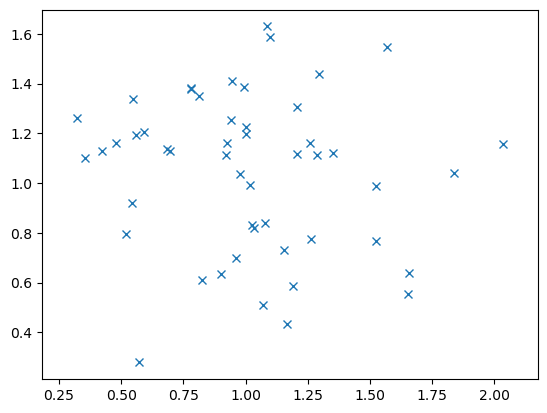

In [4]:
m = [1, 1]
sigma_square = 0.1
cv = np.eye(2) * sigma_square
x, y = np.random.multivariate_normal(m, cv, 50).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [5]:
import networkx as nx
import torch_geometric

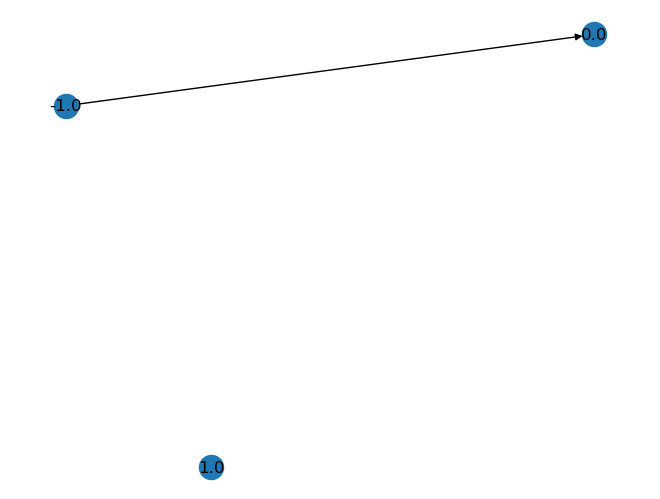

In [6]:
edge_index = torch.tensor([[0],
                          [1]], dtype=torch.long)
#edge_index.add(torch.tensor([[1], [1]], dtype=torch.long))
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
labeld = {node: val for node, val in enumerate(list(x.numpy().flatten()))}
nx.draw(g, labels=labeld, with_labels=True)

In [7]:
edge_index

tensor([[0],
        [1]])

In [8]:
from MultiClassCSBM import MultiClassCSBM

In [9]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)

1
70
8710


In [10]:
data = dataset[0]
data.is_undirected()

True

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[:int(0.8 * data.num_nodes)] = 1

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

In [15]:
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask[int(0.8 * data.num_nodes):] = 1
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[test_mask] == data.y[test_mask]).sum()
acc = int(correct) / int(test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6532


In [16]:
data = MultiClassCSBM().data